Задача:
1. Сравните результат между тестом и контролем по двум кейсам:

- Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
- Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.
2. Напишите выводы, которые можно сделать на основе анализа примененных критериев

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [93]:
df = pd.read_csv('hw_bootstrap.csv',sep=";")

In [94]:
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         1000 non-null   int64 
 1   value              1000 non-null   object
 2   experimentVariant  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [96]:
df.drop(columns='Unnamed: 0', inplace=True)

In [97]:
df.value=df.value.str.replace(',','.').astype({'value':'float64'})

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   value              1000 non-null   float64
 1   experimentVariant  1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


1.1. Решаем первую часть задачи с np.mean.

In [99]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic=np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

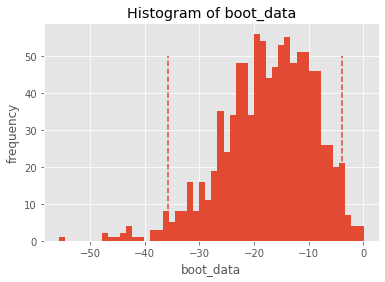

In [100]:
booted_data = get_bootstrap(df.query('experimentVariant=="Control"').value, 
                            df.query('experimentVariant=="Treatment"').value, boot_it = 1000)

In [101]:
booted_data["p_value"]

0.03709953991624699

In [102]:
booted_data["ci"]

,0
0.025,-35.833329
0.975,-3.971838


In [103]:
mannwhitneyu(df.query('experimentVariant=="Control"').value,df.query('experimentVariant=="Treatment"').value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

1.1. Решаем вторую часть задачи с np.median.

In [104]:
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic=np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # median() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

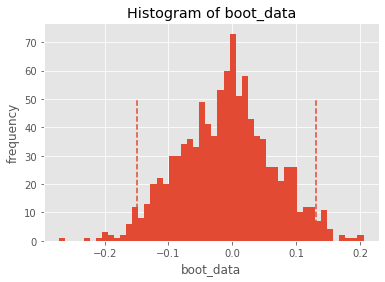

In [106]:
booted_data = get_bootstrap_median(df.query('experimentVariant=="Control"').value, 
                            df.query('experimentVariant=="Treatment"').value, boot_it = 1000)

In [107]:
booted_data["p_value"]

0.9249050266724846

In [108]:
booted_data["ci"]

,0
0.025,-0.149298
0.975,0.131418


In [64]:
mannwhitneyu(df.query('experimentVariant=="Control"').value,df.query('experimentVariant=="Treatment"').value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

2. Напишите выводы, которые можно сделать на основе анализа примененных критериев

Выводы: 
1. В Treatment есть 5 значительных выбросов, которые влияют на результат в зависимости от применяемого метода. С учётом их значительного отличия от других данных и их немногочисленности необходимо понять их природу, прежде чем принять нулевую гипотезу.
2. Поскольку среднее-mean очень чувствительно к выбросам, то bootstrap со статистикой mean показало значимый результат. При удалении из выборки этих выбросов ситуация меняется, что видно из упражнения ниже, и нулевая гипотеза может быть оставлена.

In [85]:
df.query('value>100 & experimentVariant=="Treatment"').count()

value                5
experimentVariant    5
dtype: int64

  0%|          | 0/1000 [00:00<?, ?it/s]

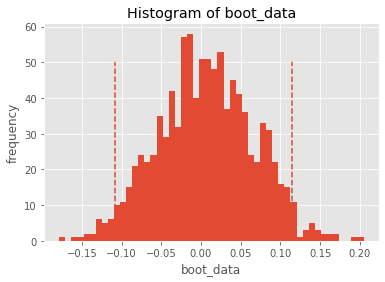

In [109]:
booted_data = get_bootstrap(df.query('experimentVariant=="Control"').value, 
                            df.query('experimentVariant=="Treatment" & value <100').value, boot_it = 1000)

In [110]:
booted_data["p_value"]

0.9111996874335677

In [111]:
booted_data["ci"]

,0
0.025,-0.108608
0.975,0.115004
